In [1]:
%matplotlib inline

from image_registration import chi2_shift
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import numpy as np
import cv2

In [21]:
all_imgs = !ls 210226_Bladder_TMA1_reg35/1_shading_correction/*.tif | grep DAPI
for i,z in enumerate(all_imgs):
    print(i, z)
    
print()
after_imgs = !ls 210226_Bladder_TMA1_reg35/2_cycle_alignment/*.tif | grep DAPI
for i,z in enumerate(after_imgs):
    print(i, z)
    
print()
stitched_imgs = !ls 210226_Bladder_TMA1_reg35/4_stitching/*.tif | grep DAPI
for i,z in enumerate(stitched_imgs):
    print(i, z)

0 210226_Bladder_TMA1_reg35/1_shading_correction/210226_Bladder_TMA1_reg35_cycle01_channel00_DAPI_4.tif
1 210226_Bladder_TMA1_reg35/1_shading_correction/210226_Bladder_TMA1_reg35_cycle02_channel00_DAPI_8.tif
2 210226_Bladder_TMA1_reg35/1_shading_correction/210226_Bladder_TMA1_reg35_cycle03_channel00_DAPI_12.tif
3 210226_Bladder_TMA1_reg35/1_shading_correction/210226_Bladder_TMA1_reg35_cycle04_channel00_DAPI_16.tif
4 210226_Bladder_TMA1_reg35/1_shading_correction/210226_Bladder_TMA1_reg35_cycle05_channel00_DAPI_20.tif
5 210226_Bladder_TMA1_reg35/1_shading_correction/210226_Bladder_TMA1_reg35_cycle06_channel00_DAPI_24.tif
6 210226_Bladder_TMA1_reg35/1_shading_correction/210226_Bladder_TMA1_reg35_cycle07_channel00_DAPI_28.tif
7 210226_Bladder_TMA1_reg35/1_shading_correction/210226_Bladder_TMA1_reg35_cycle08_channel00_DAPI_32.tif
8 210226_Bladder_TMA1_reg35/1_shading_correction/210226_Bladder_TMA1_reg35_cycle09_channel00_DAPI_36.tif
9 210226_Bladder_TMA1_reg35/1_shading_correction/210226_B

In [22]:
import itertools
from scipy.stats import pearsonr
def get_shifts(ref, query, tilesize=200, overlap=0, min_mean=300, 
               border = 50, 
               xnorm=np.inf, ynorm=np.inf):
    assert np.all(ref.shape == query.shape)
    h,w = ref.shape
    nh = int(np.ceil((h-border) / tilesize))
    nw = int(np.ceil((w-border) / tilesize))
    nh += int(nh * overlap)
    nw += int(nw * overlap)
    hcoords = np.linspace(border, h-border-tilesize, nh, dtype='int')
    wcoords = np.linspace(border, w-border-tilesize, nw, dtype='int')
    
    shifts = np.zeros((nh,nw,3),dtype='float')
    
    for i,hc in enumerate(hcoords):
        for j,wc in enumerate(wcoords):
            r = ref[hc:hc+tilesize, wc:wc+tilesize]
            q = query[hc:hc+tilesize, wc:wc+tilesize]
            if np.mean(r) < min_mean:
                xoff=0
                yoff=0
            else:
                xoff, yoff, exoff, eyoff = chi2_shift(r, q, return_error=True, upsample_factor='auto')
            #if np.abs(xoff)>xnorm:
            #    xoff=0
            #if np.abs(yoff)>ynorm:
            #    yoff=0
            # cor = pearsonr(r.ravel(), q.ravel())
            shifts[i,j,:] = xoff, yoff, np.mean(r)
            
    return shifts

In [23]:
def cart2polar(x,y):
    theta = np.rad2deg(np.arctan2(y,x))
    if (x<0) & (y>0):
        theta = 0+theta
    if (x<0) & (y<0):
        theta = 360+theta
    if (x>0) & (y<0):
        theta = 360+theta
            
    r = np.sqrt(x**2 + y**2)
    return r, theta/360

from matplotlib.colors import hsv_to_rgb
def color_shifts(shifts, r_norm=None):
    hsv = np.zeros_like(shifts)
    for i,j in itertools.product(range(shifts.shape[0]), range(shifts.shape[1])):
        comp = shifts[i,j,:2]
        r,theta = cart2polar(comp[0],comp[1])
        hsv[i,j,:] = theta, r, 1
        
    if r_norm is None: 
        hsv[:,:,1] /= hsv[:,:,1].max()
    else:
        rlayer = hsv[:,:,1].copy()
        rlayer[rlayer>r_norm] = r_norm
        rlayer = rlayer/r_norm
        hsv[:,:,1] = rlayer
    
    rgb = np.zeros_like(hsv)
    for i,j in itertools.product(range(shifts.shape[0]), range(shifts.shape[1])):
        color = hsv_to_rgb(hsv[i,j,:])
        rgb[i,j,:] = color
    
    return rgb

from matplotlib.colors import rgb2hex
def scatter_shifts(shifts, rgb, lims=None, save=None, ax=None):
    xs = []
    ys = []
    colors = []
    for i,j in itertools.product(range(shifts.shape[0]), range(shifts.shape[1])):
        xs.append(shifts[i,j,0])
        ys.append(shifts[i,j,1])
        colors.append(rgb2hex(rgb[i,j,:]))
        
    if lims is None:
        xtnt = np.max(np.abs(xs))
        ytnt = np.max(np.abs(ys))
        lims = np.max([xtnt, ytnt])
    
    if ax is None:
        
        plt.figure(figsize=(2,2))
        ax = plt.gca()
    ax.set_aspect('equal')
    ax.scatter(xs, ys, color=colors, lw=0.1, ec='k')
    ax.set_xlabel('xoff')
    ax.set_ylabel('yoff')
    ax.axhline(0, color='k', lw=0.5, zorder=0)
    ax.axvline(0, color='k', lw=0.5, zorder=0)
    ax.set_xlim([-lims, lims])
    ax.set_ylim([-lims, lims])
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight', transparent=True)

(4096, 4096) (4096, 4096)
(4096, 4096) (4096, 4096)
(4096, 4096) (4096, 4096)
(4096, 4096) (4096, 4096)
(4096, 4096) (4096, 4096)


KeyboardInterrupt: 

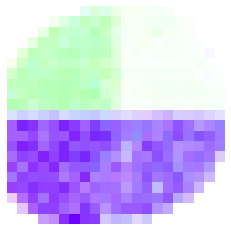

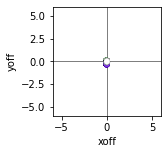

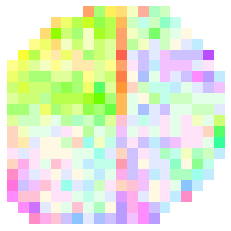

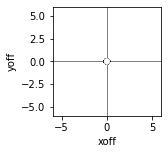

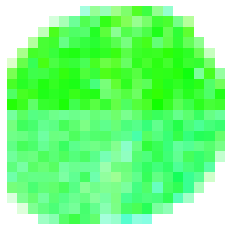

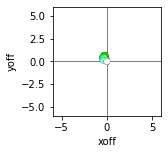

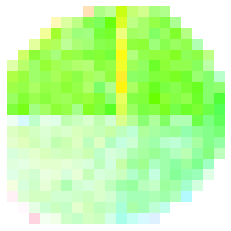

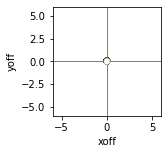

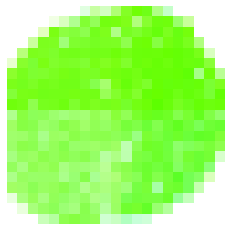

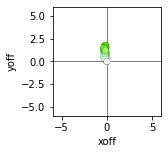

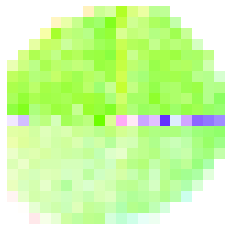

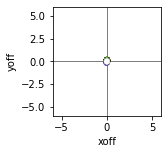

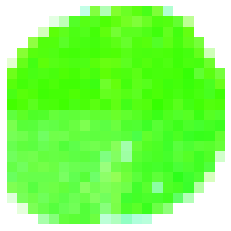

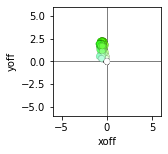

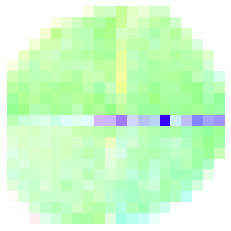

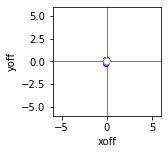

In [24]:
from matplotlib import rcParams
rcParams['svg.fonttype'] = 'none'

cycle_index = 1
for cycle_index in range(1,10):
    ref_img = cv2.imread(all_imgs[0],-1)
    before_img = cv2.imread(all_imgs[cycle_index],-1)
    print(ref_img.shape, before_img.shape)
    
    shifts = get_shifts(ref_img, before_img, tilesize=200, overlap=0.0)
    
    stitched_ref = cv2.imread(stitched_imgs[0],-1)
    aligned_img = cv2.imread(stitched_imgs[cycle_index],-1)
    
    shifts_aligned = get_shifts(stitched_ref, aligned_img, tilesize=200, overlap=0.0)
    
    rgb = color_shifts(shifts)
    rgb_aligned = color_shifts(shifts_aligned)
    
    np.save(f'figures/cycle_alignment/optical_shift/cycle_{cycle_index}_shift_uncorrected.npy', shifts)
    np.save(f'figures/cycle_alignment/optical_shift/cycle_{cycle_index}_shift_corrected.npy', shifts_aligned)
    
    plt.figure()
    ax = plt.gca()
    ax.imshow(rgb)
    ax.axis('off')
    plt.savefig(f'figures/cycle_alignment/optical_shift/cycle_{cycle_index}_uncorrected.png',
                bbox_inches='tight', transparent=True)

    scatter_shifts(shifts, rgb, lims=6,
                   save = f'figures/cycle_alignment/optical_shift/cycle_{cycle_index}_uncorrected_plot.svg')
    
    plt.figure()
    ax = plt.gca()
    ax.imshow(rgb_aligned)
    ax.axis('off')
    plt.savefig(f'figures/cycle_alignment/optical_shift/cycle_{cycle_index}_corrected.png',
                bbox_inches='tight', transparent=True)

    scatter_shifts(shifts_aligned, rgb_aligned, lims=6,
                   save = f'figures/cycle_alignment/optical_shift/cycle_{cycle_index}_corrected_plot.svg')

In [ ]:
for cycle_index in range(1,10):
    shifts = np.load(f'figures/cycle_alignment/optical_shift/cycle_{cycle_index}_shift_uncorrected.npy')
    shifts_aligned = np.load(f'figures/cycle_alignment/optical_shift/cycle_{cycle_index}_shift_corrected.npy')
    
#     shifts[:,10,:] = 0
#     shifts[10,:,:] = 0
#     shifts_aligned[:,10,:] = 0
#     shifts_aligned[10,:,:] = 0
    
    rgb = color_shifts(shifts, r_norm=5)
    rgb_aligned = color_shifts(shifts_aligned, r_norm=5)
    
    plt.figure()
    ax = plt.gca()
    ax.imshow(rgb)
    ax.axis('off')
    plt.savefig(f'figures/cycle_alignment/optical_shift/cycle_{cycle_index}_uncorrected.png',
                bbox_inches='tight', transparent=True)

    scatter_shifts(shifts, rgb, lims=6,
                   save = f'figures/cycle_alignment/optical_shift/cycle_{cycle_index}_uncorrected_plot.svg')
    
    plt.figure()
    ax = plt.gca()
    ax.imshow(rgb_aligned)
    ax.axis('off')
    plt.savefig(f'figures/cycle_alignment/optical_shift/cycle_{cycle_index}_corrected.png',
                bbox_inches='tight', transparent=True)

    scatter_shifts(shifts_aligned, rgb_aligned, lims=6,
                   save = f'figures/cycle_alignment/optical_shift/cycle_{cycle_index}_corrected_plot.svg')